# IBM Open Science Prize 2022 

**Group:** _Stefan Sack, Stefano Barison_

In [1]:
## TODO: little introduction?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1 - Classical simulation 

In [3]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [4]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

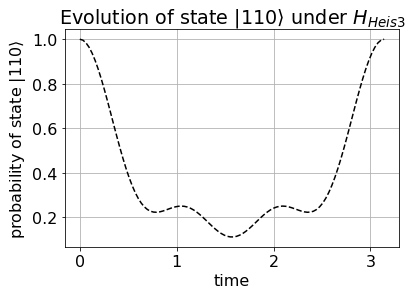

In [5]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110_exact = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

## 2- The Open Science Prize

The aim is to time evolve the state $|110\rangle$ to time $t=\pi$ under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$. The evolution must be done using Trotterization with at least 4 steps ($n\geq4$).

### 2.1 - Trotterization comparison

For this reason, we will start analysing how a Trotterization on a perfect quantum device will evolve the state $|110\rangle$ to time $t=\pi$ given a fixed number of Trotter steps.

In [6]:
## Import functions from Qiskit
from qiskit                  import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer    import QasmSimulator
from qiskit.tools.monitor    import job_monitor
from qiskit.circuit          import Parameter
from qiskit.quantum_info     import Statevector
from qiskit.opflow.state_fns import CircuitStateFn

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info                  import state_fidelity

In [7]:
## In the "trotter_function.py" file are contained all the functions useful for a perfect Trotter simulation
from trotter_functions import Heisenberg_Trotter_1st_ord, Heisenberg_Trotter_1st_ord_compressed

In [8]:
## Let's simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
t_steps = [4,8,12]
probs_110_trott = {4:[],8:[],12:[]}
t = Parameter("t")

for t_n in t_steps:
    for sim_t in ts:
        # Initialise the circuit
        trott_qr = QuantumRegister(3)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x([1,2])
    
        # Append the Trotterization
        trott_step  = Heisenberg_Trotter_1st_ord(num_qubits=3,trotter_steps=t_n,p=t,target_time=sim_t).to_instruction()
        trott_qc.append(trott_step, [trott_qr[0], trott_qr[1], trott_qr[2]])
    
    
        trott_wfn = CircuitStateFn(trott_qc)
        trott_ovp = np.abs((~initial_state@trott_wfn).eval())**2
        probs_110_trott[t_n].append(trott_ovp)
    print(str(t_n)+" steps completed")

4 steps completed
8 steps completed
12 steps completed


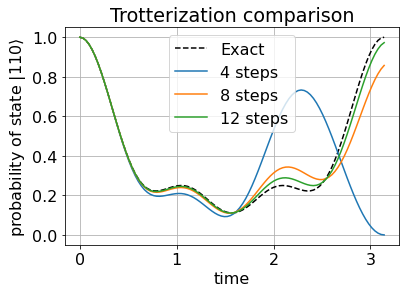

In [9]:
# Now plot the comparison
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
for (i,t_n) in enumerate(t_steps):
    plt.plot(ts, probs_110_trott[t_n],color="C"+str(i),label=str(t_n)+" steps")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Trotterization comparison')
plt.legend()
plt.grid()
plt.show()

As we can see, four Trotter steps are not enough to correctly time evolve the target state to $t=\pi$.
As expected, increasing the Trotter steps we get closer and closer to the exact simulation.

However, we are limited in the circuit depth that we can implement on hardware. For this reason, the aim of this notebook will be to compress the greatest Trotterization accuracy into the shortest possible circuit, before even applying error mitigation techniques.

### 2.2 Compress the Trotter step

The first step is to reduce the number of gates required by a single Trotter step. 
To this point, a single Trotter step requires $12$ CNOTs.

We can easily reduce it to $6$ using an optimal circuit for the $XX+YY+ZZ$ rotation presented in [Quantum computers as universal quantum simulators: state-of-art and perspectives](https://arxiv.org/abs/1907.03505).

In particular, we will consider the decomposition in Fig. 4b, while the initial Trotterization corresponds to the decomposition in Fig. 4a.

With this decomposition, 4 Trotter steps on 3 qubits will now require 24 CNOTs instead of 48.

To show that the two decompositions are equivalent, let us compare a single uncompressed & compressed Trotter step.

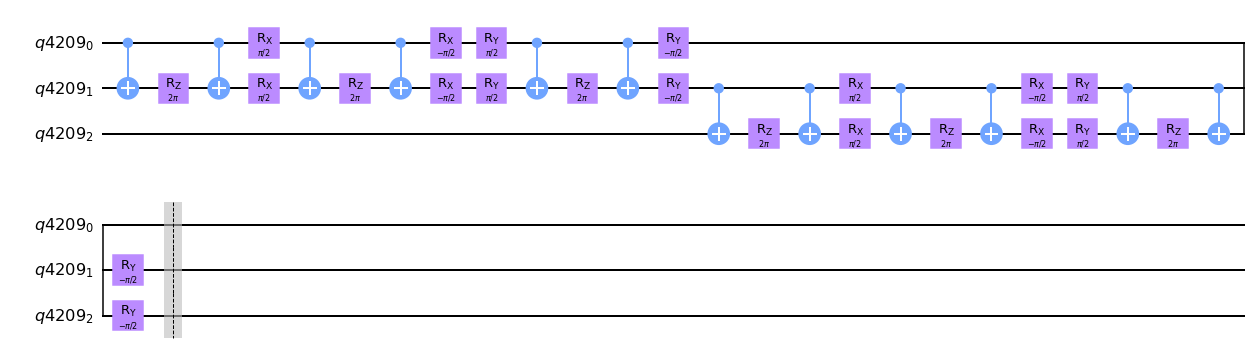

In [11]:
qc_1st_ord = Heisenberg_Trotter_1st_ord(3, 1, np.pi, np.pi)
qc_1st_ord.decompose().decompose().draw("mpl")

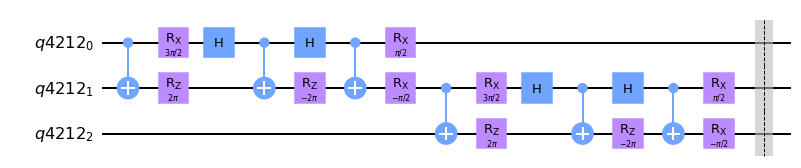

In [12]:
qc_1st_ord_compressed = Heisenberg_Trotter_1st_ord_compressed(3, 1, np.pi, np.pi)
qc_1st_ord_compressed.decompose().decompose().draw("mpl")

In [13]:
#TODO: maybe better to put arbitrary angles here

Using the qiskit Operator object we can check that they are exactly the same.
A detailed derivation of the equivalence can be found in the original paper, mentioned above.

In [14]:
from qiskit.quantum_info import Operator

In [15]:
Op_1st_order = Operator(qc_1st_ord)
Op_1st_order_compressed = Operator(qc_1st_ord_compressed)

print("The two circuits are the same: ", Op_1st_order.equiv(Op_1st_order_compressed))

The two circuits are the same:  True


Great, we will thus form now on use the compressed circuit!

### 2.3 Variational compression - the pVQD algorithm

In [16]:
## TODO: add the pVQD algorithm + explanation

In [17]:
# What I need is a one fuction that creates the whole cirucit and the optimal paramters are simply passed 

In [18]:
from qiskit.circuit import Parameter, ParameterVector
from qiskit.aqua.components.optimizers import COBYLA
from qiskit import Aer
num_qubits = 3

In [19]:
# TODO: integrate this into the trotter_functions.py
def R_xyz_variational(theta):
    
    t_qr = QuantumRegister(2)
    t_qc = QuantumCircuit(t_qr, name='XYZ')
    
    t_qc.cnot(0,1)
    t_qc.rx(2*theta-np.pi/2, 0)
    t_qc.rz(2 * theta, 1)
    t_qc.h(0)
    t_qc.cnot(0,1)
    t_qc.h(0)
    t_qc.rz(-2 * theta, 1)
    t_qc.cnot(0,1)
    t_qc.rx(np.pi/2,0)
    t_qc.rx(-np.pi/2,1)

    return t_qc

In [20]:
# TODO: integrate this into the trotter_functions.py
def get_var_form(theta):
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    
    # This need to be slightly adopted due to a bug in the error mitigation software mitiq
    qc.rx(np.pi, [3, 5]) 
    qc.id([0, 1, 2, 4, 6])

    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

    for trotter_step in range(0, 4):
        for i in range(0, num_qubits - 1):
            Trot_qc.append(R_xyz_variational(theta[trotter_step]).to_instruction(), [Trot_qr[i], Trot_qr[i+1]])
    
    Trot_gate = Trot_qc.to_instruction()
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    # qc.measure(qr, [qr[1], qr[3], qr[5]])
    return qc, qr

In [21]:
theta = ParameterVector('theta', 4) # there are 4 Trotter steps which we now treat as variational parameters

In [22]:
# This is the cost function to find the optimal parameters, this should be done via the pVQD instead!
def objective_function(params):

    backend = Aer.get_backend('statevector_simulator')

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    # This need to be slightly adopted due to a bug in the error mitigation software mitiq
    qc.rx(np.pi, [3, 5]) 
    qc.id([0, 1, 2, 4, 6])
    result = execute(qc, backend).result()
    target_state = result.get_statevector(qc) 

    qc, _ = get_var_form(theta)
    qc = qc.bind_parameters({theta: params})

    result = execute(qc, backend).result()
    state = result.get_statevector(qc)
    cost = 1 - state_fidelity(target_state, state)
    
    return cost

In [23]:
# This will be replaced by the pVQD!!!

# Optimize the circuit parameters
optimizer = COBYLA(maxiter=500, tol=0.0001)
params = (np.pi/4)*np.ones(4)
ret = optimizer.optimize(num_vars=4, objective_function=objective_function, initial_point=params)

In [26]:
qc, qr = get_var_form(ret[0])

### 2.4 Final compression

In [27]:
## TODO: reduction to 15 CNOTs?

## 3- Final Implementation

In [28]:
# 3-1 Error mitigation

Here we will use error mitigation to further improve the result. In particular we will be using Zero Noise Extrapolation (ZNE). For this the circuit depth is extended by unfolding gates, $G \rightarrow G G^\dagger G$. The circuit remains the same this way (since $G^\dagger G = I$), though the noise is increased. This way we can obtain results for different noise levels and extrapolate to the ideal, zero noise case. This prodecure is nicely wrapped into a single function provided by [mitiq](https://mitiq.readthedocs.io/en/stable/from). One simply has to be careful with minor bugs present in mitiq, we will comment on them below. 

In [29]:
from mitiq.zne.inference import PolyFactory
from mitiq.zne.zne import execute_with_zne

In [30]:
provider = IBMQ.load_account()

In [31]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

In [32]:
# Setting all the parameters that are need
shots = 8192
backend = sim_noisy_jakarta

In [33]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

To use mitiq for noise mitigation we need to wrap the fidelity estimation via state tomography into a single "executor" function.

In [34]:
# Function that does state tomography and returns the fidelity
# To be used in the error mitigation (mitq)
def executor(circ):
    
    # Create list of state tomography circuits out of circ
    st_qcs = state_tomography_circuits(circ, [qr[1], qr[3], qr[5]])

    # Execute the state tomography circuits 
    job = execute(st_qcs, backend, optimization_level=3, shots=shots)
    print('Job ID', job.job_id())
    
    return state_tomo(job.result(), st_qcs)

In [35]:
# method: scale noise by 1, 2, 3, and 4, then extrapolate quadratically to the zero noise limit.
poly_fac = PolyFactory(scale_factors=[1.0, 2.0, 3.0], order=2)

In [36]:
# Repeat fidelity measurement
reps = 2 # Needs to be 8 in the final execution
fids = []
for _ in range(reps):
    
    # Circuit needs to be decomposed for mitq
    fids.append(execute_with_zne(qc.decompose().decompose(), executor, factory=poly_fac)) 

Job ID 13ce3f0b-efd8-4822-b0be-9aa81de35e9f
Job ID 90da9b72-5b54-45b7-9c63-75cd5b813dbc
Job ID 6f5c881b-1c98-475b-95d4-7ee3021c445d
Job ID 6f5d2630-6e66-4613-a60b-6b62805b0e9d
Job ID ddac6bdd-74a3-4ca3-b91c-89de43ea2477
Job ID 5ce8b958-fb43-4a97-a6c5-053138253efb


In [37]:
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.7051 ± 0.0086
